In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import sys
import scipy.io as sio
import skimage.io

sys.path.append("../Visualization/")

from optparse import OptionParser
from Preprocess_Utilities import *
from Visualization import *

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
parser = OptionParser()

parser.add_option("-m", "--image", dest="img_path")
parser.add_option("-r", "--road", dest="road_dir_path")
parser.add_option("-s", "--save_dir", dest="save_dir_path")
parser.add_option("--step", type="int", dest="step")
parser.add_option("-d", "--divide", action="store_true", dest="divide")
parser.add_option("-n", "--name", dest="name")

(options, args) = parser.parse_args()

img_path = options.data_path
road_dir_path = options.road_dir_path
save_dir_path = options.save_dir_path
step = options.step
divide = options.divide

if not img_path:
    img_path = '/localdata/u6142160/Data/090085/All_Data/090085_20170531.h5'
if not road_dir_path:
    road_dir_path = '/localdata/u6142160/Data/090085/Road_Data/'
if not save_dir_path:
    print('no save_dir_path')
    sys.exit()
if not step:
    print('no step specified')
    sys.exit()
if not name:
    name = "patch_set.h5"

save_dir_path = save_dir_path.strip('/') + '/'
print("will be saved into ", save_dir_path, name)

In [2]:
img_path = '../Data/090085/All_Data/090085_20170531.h5'
road_dir_path = '../Data/090085/Road_Data/'

In [3]:
# create road mask paths list
road_type = np.array(["motorway", "trunk", "primary", "secondary", "tertiary", "unclassified", "track", # 0-6
                      "residential", "service", "road", "living_street", # 7-10
                      "all_roads"]) # 11 
#                       "motor_trunk_pri_sec_tert_uncl_track", "motor_trunk_pri_sec_tert_uncl"]) # 12-13

road_mask_path = np.char.add(road_dir_path, 
                             np.char.add(np.char.add(road_type, '/'), np.char.add(road_type, '.tif')))

In [4]:
# read in raw image
raw_image = np.array(h5py.File(img_path)['scene'])

# read in road mask
print('road mask loaded in ...')
road_img_list = []
for cur_path in road_mask_path:
    print(cur_path)
    road_img_list.append(skimage.io.imread(cur_path))

road_img_list = np.array(road_img_list)

# assert 0-1 coding
assert (np.logical_or(road_img_list == 1, road_img_list == 0)).all()

road mask loaded in ...
../Data/090085/Road_Data/motorway/motorway.tif
../Data/090085/Road_Data/trunk/trunk.tif
../Data/090085/Road_Data/primary/primary.tif
../Data/090085/Road_Data/secondary/secondary.tif
../Data/090085/Road_Data/tertiary/tertiary.tif
../Data/090085/Road_Data/unclassified/unclassified.tif
../Data/090085/Road_Data/track/track.tif
../Data/090085/Road_Data/residential/residential.tif
../Data/090085/Road_Data/service/service.tif
../Data/090085/Road_Data/road/road.tif
../Data/090085/Road_Data/living_street/living_street.tif
../Data/090085/Road_Data/all_roads/all_roads.tif


In [5]:
# combine the road mask
print("Used masks ... ")
combined_road_mask = 0
for i in [0,1,2,3,4,5,6]:
    print(road_mask_path[i])
    combined_road_mask += road_img_list[i]
print(combined_road_mask.shape, (combined_road_mask > 1).any())

combined_road_mask[np.where(combined_road_mask > 1)] = 1
assert (np.logical_or(combined_road_mask == 1, combined_road_mask == 0)).all()

Used masks ... 
../Data/090085/Road_Data/motorway/motorway.tif
../Data/090085/Road_Data/trunk/trunk.tif
../Data/090085/Road_Data/primary/primary.tif
../Data/090085/Road_Data/secondary/secondary.tif
../Data/090085/Road_Data/tertiary/tertiary.tif
../Data/090085/Road_Data/unclassified/unclassified.tif
../Data/090085/Road_Data/track/track.tif
(7961, 8091) True


In [6]:
# save the combined road mask
save_dir_path = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/"
skimage.io.imsave(save_dir_path + 'road_mask.tif', combined_road_mask)

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/road_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


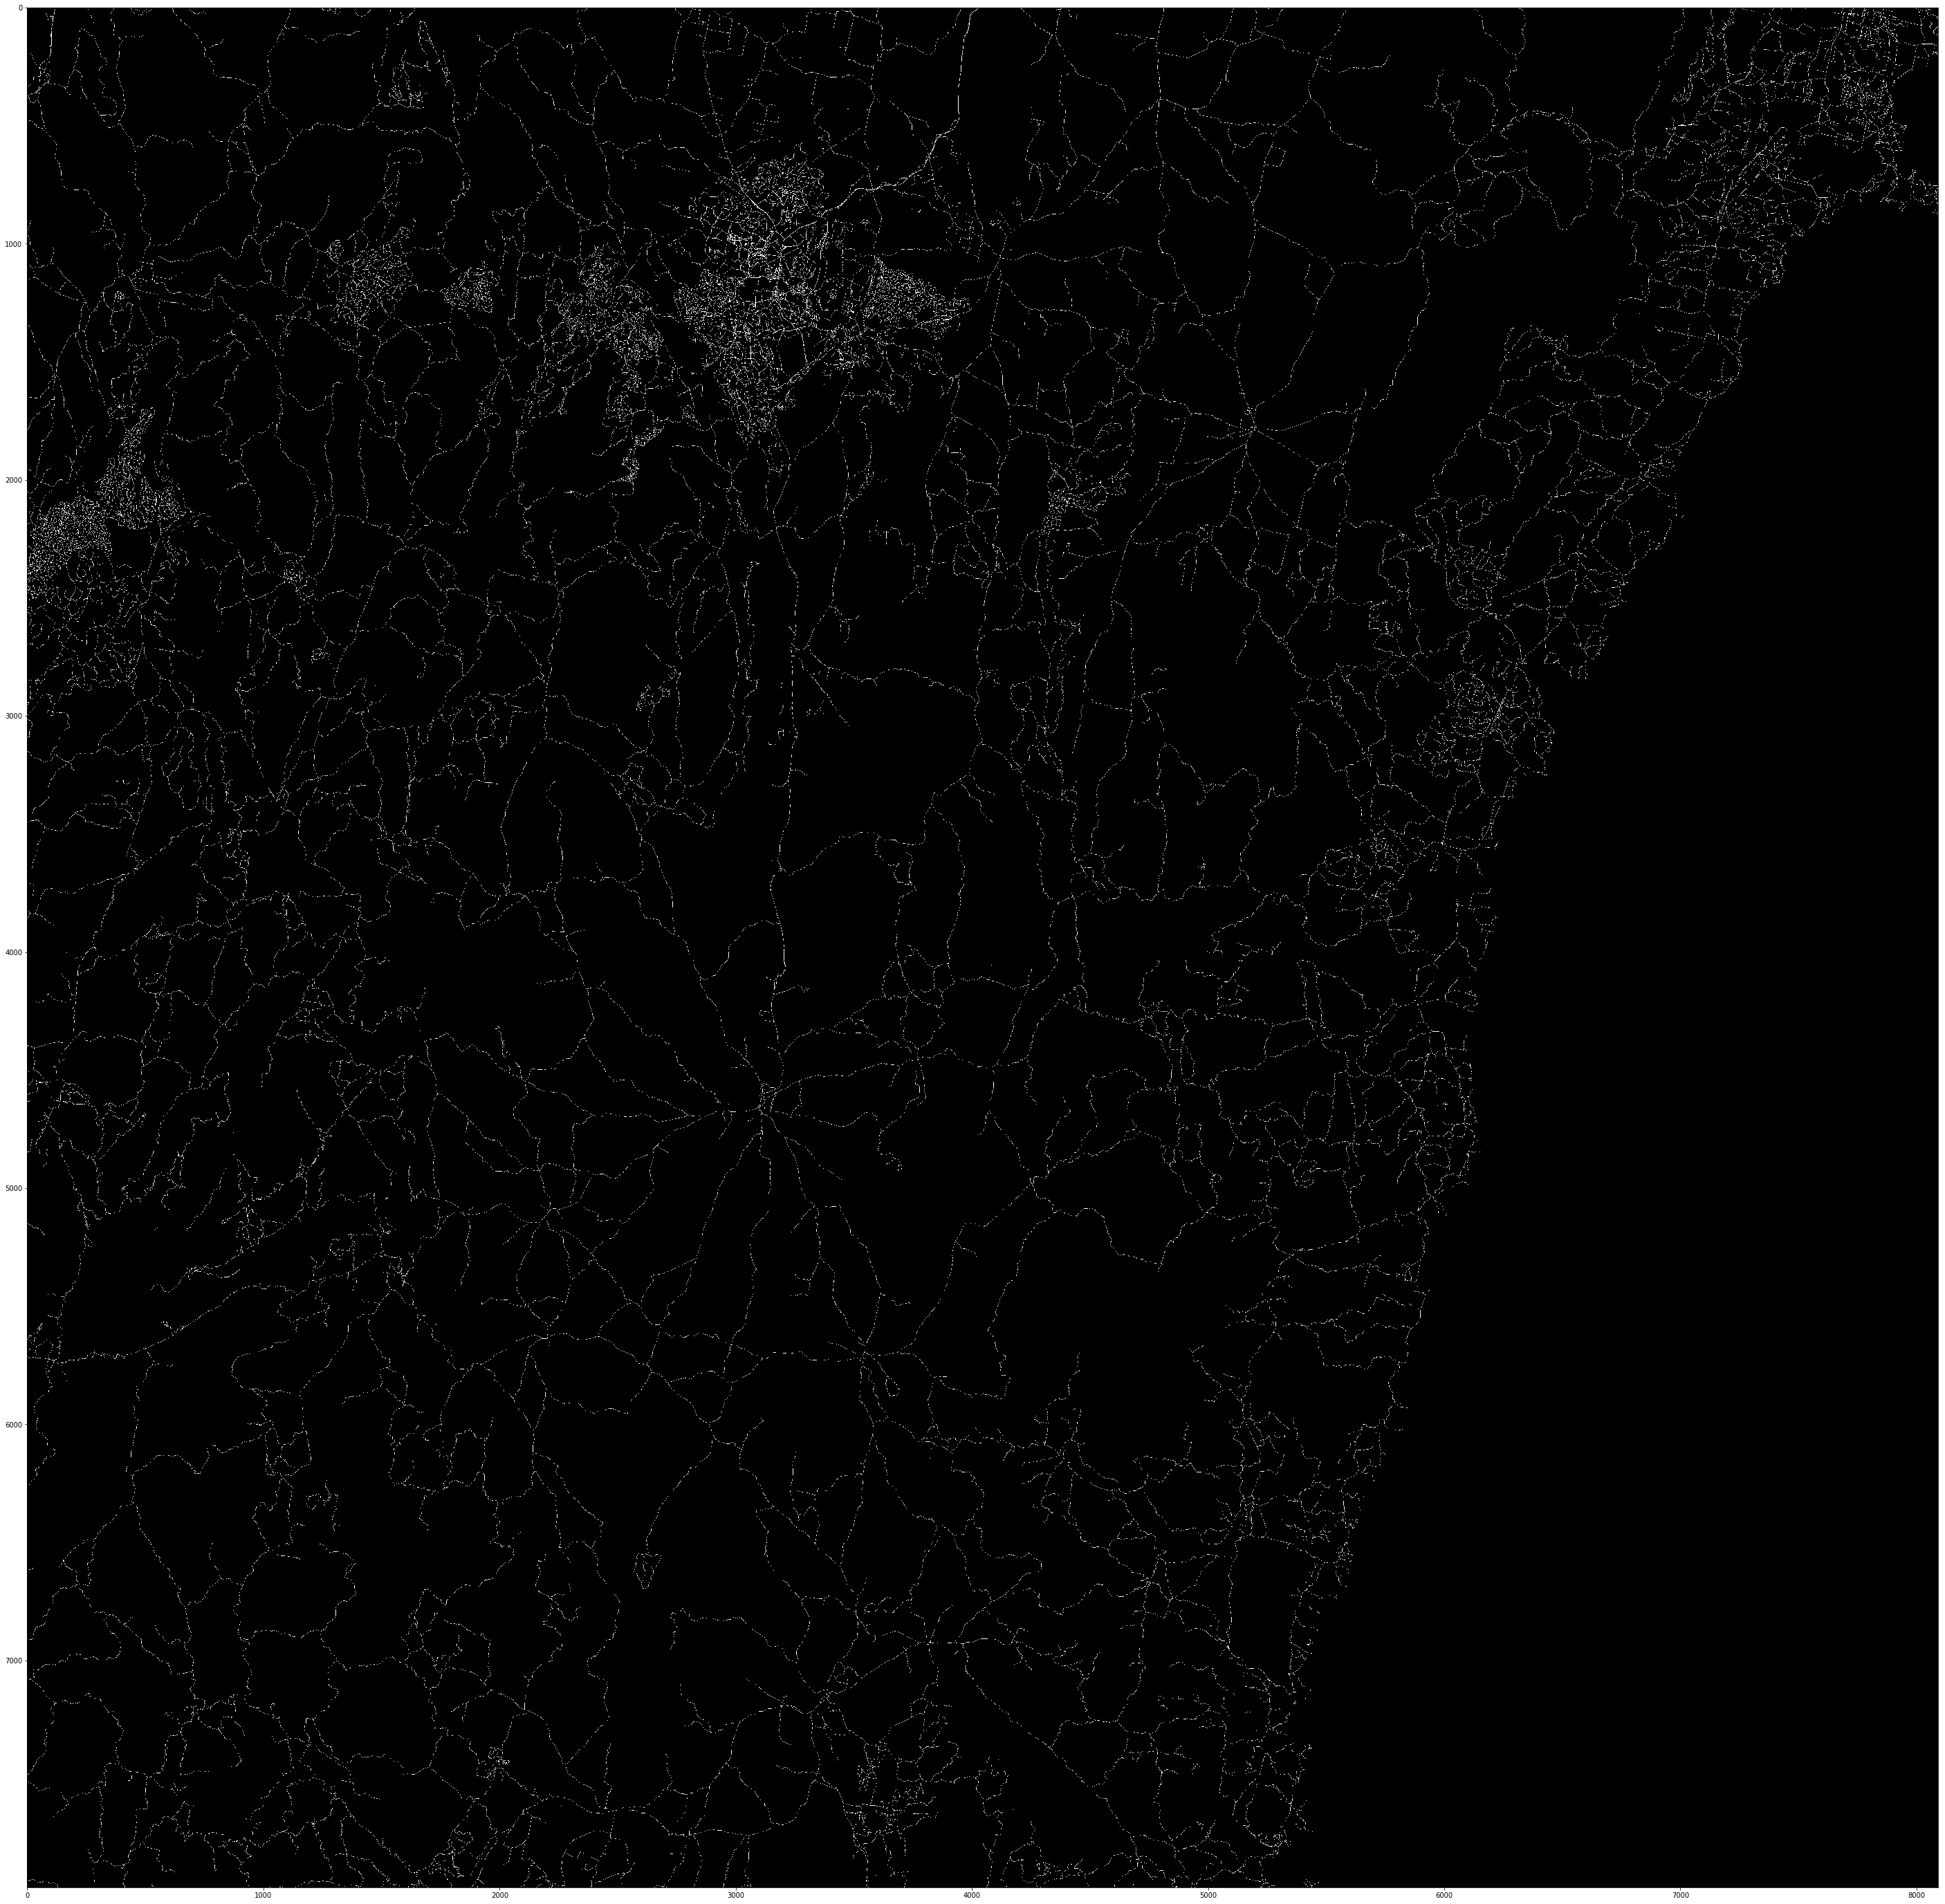

In [11]:
plt.figure(figsize=(50,50))
plt.imshow(combined_road_mask, cmap=plt.get_cmap('gray'))
plt.show()

create top-left coordinate

In [13]:
divide = True
step = 8
save_dir_path = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/"
name = "posneg_topleft_coordinate_8" ???
if divide:
    # record the top-left coordinate of each possible patches & divide into pos/neg groups
    pos_topleft_coordinate = []
    neg_topleft_coordinate = []

    row_offset = 0
    while (row_offset + step <= raw_image.shape[1]):
        col_offset = 0
        while (col_offset + step <= raw_image.shape[2]):
            cur_img_patch = raw_image         [:,row_offset:row_offset+step, col_offset:col_offset+step]
            cur_road_mask = combined_road_mask[  row_offset:row_offset+step, col_offset:col_offset+step]

            if (cur_img_patch != -9999).all():
                if cur_road_mask [int(step/2), int(step/2)] == 1: # positive example
                    pos_topleft_coordinate.append((row_offset, col_offset))
                else: # negative example
                    neg_topleft_coordinate.append((row_offset, col_offset))

            col_offset += 1
        row_offset += 1

    pos_topleft_coordinate = np.array(pos_topleft_coordinate)
    neg_topleft_coordinate = np.array(neg_topleft_coordinate)
    print("pos coordinates' shape=", pos_topleft_coordinate.shape)
    print("neg coordinates' shape=", neg_topleft_coordinate.shape)

    # save set
    h5_path = save_dir_path + name
    h5f = h5py.File(h5_path, 'w')
    h5f.create_dataset(name='positive_example', data=pos_topleft_coordinate)
    h5f.create_dataset(name='negative_example', data=neg_topleft_coordinate)
    h5f.close()
    
else:
    # record the top-left coordinate of each possible patches sequentially
    step = 28
    topleft_coordinate = []

    row_offset = 0
    while (row_offset + step <= raw_image.shape[1]):
        col_offset = 0
        while (col_offset + step <= raw_image.shape[2]):
            cur_img_patch = raw_image         [:,row_offset:row_offset+step, col_offset:col_offset+step]
            cur_road_mask = combined_road_mask[  row_offset:row_offset+step, col_offset:col_offset+step]

            if (cur_img_patch != -9999).all():
                topleft_coordinate.append((row_offset, col_offset))

            col_offset += 1
        row_offset += 1

    topleft_coordinate = np.array(topleft_coordinate)
    print("coordinates' shape=", topleft_coordinate.shape)
    
    # save set
    h5_path = save_dir_path + name
    h5f = h5py.File(h5_path, 'w')
    h5f.create_dataset(name='topleft_coordinate', data=topleft_coordinate)
    h5f.close()
print("saved into ", h5_path)

pos coordinates' shape= (374365, 2)
neg coordinates' shape= (25134009, 2)
saved into  ../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_topleft_coordinate_8 posneg_topleft_coordinate_8


In [ ]:
# # plot out some patches
# # [0-21450]
# index = 1000

# has_road = road_existence[index]
# mask = road_patch[index]
# patch = np.array([image_patch[index][3].T, image_patch[index][2].T, image_patch[index][1].T]).T

# print(has_road, patch.max(), patch.min(), patch.shape, mask.shape)
# patch = patch * 0.0001 * 5

# # plot raw img
# plt.imshow(patch)
# plt.show()
# plt.clf()

# # plot road mask
# plt.imshow(mask, cmap=plt.get_cmap('gray'))
# plt.show()
# plt.clf()